# This notebook is for plotting the full distributions of $\langle \cos^2{\theta}\rangle_T$ as a function of $T$. It takes a while to run if you want the distributions to look smooth, but a low res. version is fast

In [3]:
from numpy import *
from PlotFuncs import *
from LabFuncs import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from numba import jit
from numpy import random
from scipy.integrate import cumtrapz
from scipy.special import erf
from scipy.stats import percentileofscore
import cmocean
from tqdm.notebook import tqdm
from scipy.optimize import fsolve


def FindPercentile(h,cc,nbins=500):
    P_costh = h/sum(h) 
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf(-P0*cc/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3)
    cval_excl = 1.64/res
    
    fs = lambda P0 : 0.05-sum(0.5*(1+erf((5-P0*cc)/sqrt(2)))*P_costh)
    res = fsolve(fs,1.64*3+5)
    cval_disc = (5+1.64)/res
    return cval_excl,cval_disc

def costh_T_histogram(fcosth2,lat,Tmax,nt=2000,nbins=2000,ngen=200000):
    '''
    This function is for making the histogram of <cos^2(th)>_T for an array of T
    thereby making a series of histograms that can be plotted
    
    INPUT:
    fcosth2 = the function name of the relevant angle, e.g. costh2N, costh2W, costh2Z
    lat = latitude in degrees
    Tmax = largest value of T to plot
    nt = number of values of T to plot
    nbins = number of bins in <cos^2(th)>_T
    ngen = number of DP polarisations to sample over
    
    OUTPUT:
    T = array of T (size=nt)
    ce = bin edges of <cos^2(th)>_T histogram (size=nbins+1)
    H = array of histograms (size=(nbins,nt))
    C_05 = 5th percentile of distribution at each T (size=nt)
    C_50 = 50th percentile of distribution at each T (size=nt)
    C_95 = 95th percentile of distribution at each T (size=nt)
    '''
    costh_X = 2*random.uniform(size=ngen)-1
    phi_X = 2*pi*random.uniform(size=ngen)
    
    T = linspace(0,Tmax,nt+1)

    c1t = zeros(shape=(ngen,nt+1))

    for i in range(0,nt+1):
        c1t[:,i] = fcosth2(T[i],costh_X,phi_X,lat)

    # Calculate the time average at each T by doing a cumulative average
    c_av = cumtrapz(c1t,T)/T[1:]
    
    # Now calculate various statistics and bin up the results into a histogram
    C_excl = zeros(shape=nt)
    C_disc = zeros(shape=nt)
    
    H = zeros(shape=(nbins,nt))
    for i in tqdm(range(0,nt)):
        H[:,i],ce = histogram(c_av[:,i],nbins,range=[0,1])
        cc = (ce[1:]+ce[0:-1])/2
    
        C_excl[i],C_disc[i] = FindPercentile(H[:,i],cc)
        
    
    return T[1:],ce,H,C_excl,C_disc


# Make three histograms for three latitudes
lat1 = 35
lat2 = 45
lat3 = 55

# North-pointing experiments first
direction_label = r'{\bf North-pointing}'
figname = 'North_costh_dist'
cmap = cmocean.cm.algae
T,ce,H1,C1_excl,C1_disc = costh_T_histogram(costh2N,lat1,4)
T,ce,H2,C2_excl,C2_disc = costh_T_histogram(costh2N,lat2,4)
T,ce,H3,C3_excl,C3_disc = costh_T_histogram(costh2N,lat3,4)

# Now we just plot the results using pcolormesh

In [13]:
shape(ce)

(2001,)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


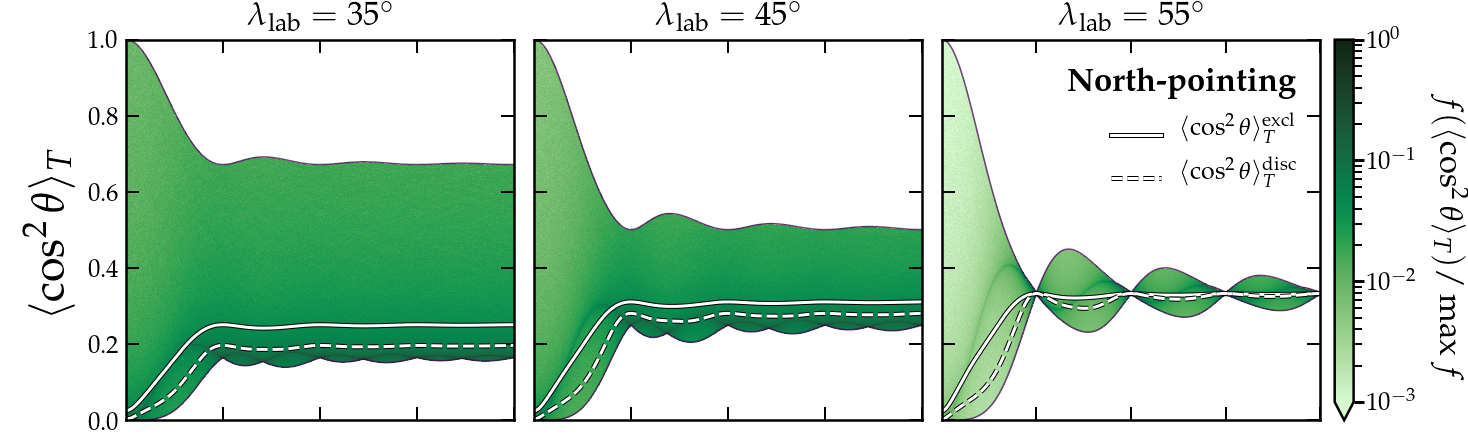

In [16]:
import matplotlib.colors as colors
import matplotlib.patheffects as pe
pek=[pe.Stroke(linewidth=5, foreground='k',alpha=1), pe.Normal()]

def Plot_costh_T_histogram(ax,T,ce,H,C_excl,C_disc,cmap,lat,direction_label,cbar_lab='',vmin=1e-3,cbar_on=False,mean_val=1/3):
    plt.sca(ax)
    norm = colors.LogNorm(vmin=vmin, vmax=1)
    cc = (ce[1:]+ce[0:-1])/2
    im = ax.pcolormesh(T,ce,(H/amax(H)),cmap=cmap,norm=norm,rasterized=True)
    ax.plot(T,C_excl,'w-',path_effects=pek,lw=3,label=r'$\langle \cos^2{\theta}\rangle^{\rm excl}_T$')
    ax.plot(T,C_disc,'w--',path_effects=pek,lw=3,label=r'$\langle \cos^2{\theta}\rangle^{\rm disc}_T$')
    ax.contour(T,ce[1:],(H/amax(H)),levels=0,alpha=0.7)
    #ax.axhline(mean_val,color='k',lw=2.5,linestyle='--')
    if cbar_on:
        cbar(im,extend='min')
        plt.gcf().text(0.95,0.50,cbar_lab,ha='center',rotation_mode='anchor',rotation=-90,fontsize=33)
    return

xlab = ''
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'
fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_excl,C1_disc,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_excl,C2_disc,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_excl,C3_disc,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

ax1.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat1))+r'$^\circ$',fontsize=33)
ax2.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat2))+r'$^\circ$',fontsize=33)
ax3.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat3))+r'$^\circ$',fontsize=33)

ax3.legend(frameon=False,bbox_to_anchor=(1,0.85),fontsize=25,loc='upper right')

plt.gcf().text(0.865,0.78,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

MySaveFig(fig,figname)

In [17]:
# Exactly the same but for zenith-pointing experiments
direction_label = r'{\bf Zenith-pointing}'
figname = 'Zenith_costh_dist'
cmap = cm.Reds
T,ce,H1,C1_excl,C1_disc = costh_T_histogram(costh2Z,lat1,4)
T,ce,H2,C2_excl,C2_disc = costh_T_histogram(costh2Z,lat2,4)
T,ce,H3,C3_excl,C3_disc = costh_T_histogram(costh2Z,lat3,4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


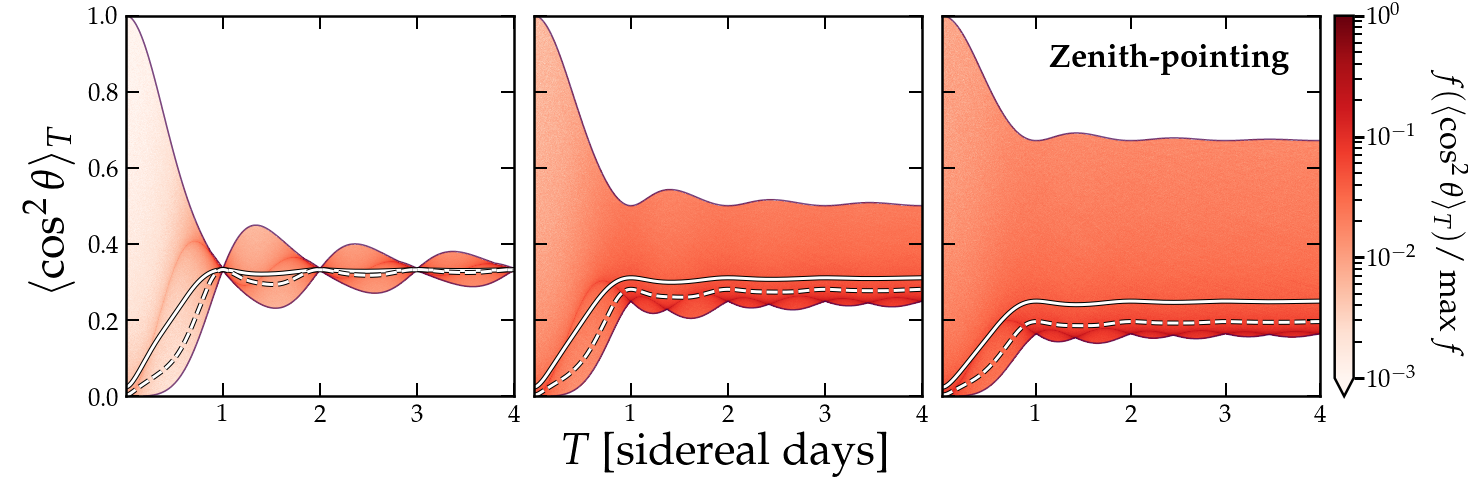

In [18]:
xlab = r'$T$ [sidereal days]'
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'
fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_excl,C1_disc,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_excl,C2_disc,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_excl,C3_disc,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

plt.gcf().text(0.86,0.78,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])

MySaveFig(fig,figname)

In [19]:
# Exactly the same but for zenith-pointing experiments
direction_label = r'{\bf West-pointing}'
figname = 'West_costh_dist'
cmap = cm.Blues
T,ce,H1,C1_excl,C1_disc = costh_T_histogram(costh2W,lat1,4)
T,ce,H2,C2_excl,C2_disc = costh_T_histogram(costh2W,lat2,4)
T,ce,H3,C3_excl,C3_disc = costh_T_histogram(costh2W,lat3,4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


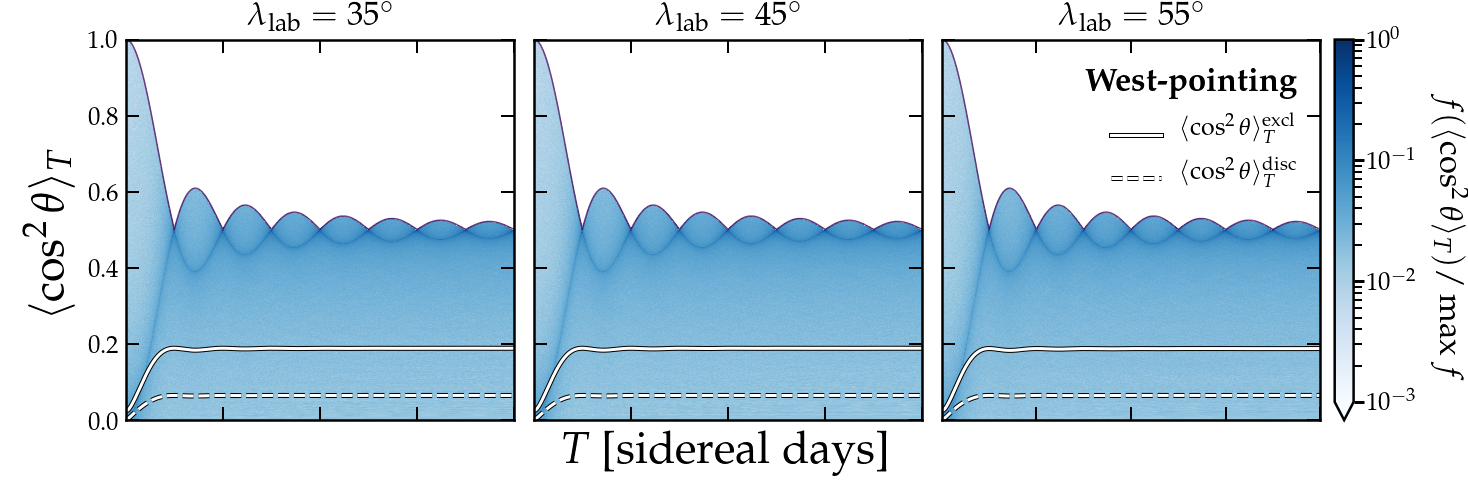

In [20]:
xlab = r'$T$ [sidereal days]'
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'

fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_excl,C1_disc,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_excl,C2_disc,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_excl,C3_disc,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

ax1.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat1))+r'$^\circ$',fontsize=33)
ax2.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat2))+r'$^\circ$',fontsize=33)
ax3.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat3))+r'$^\circ$',fontsize=33)

ax3.legend(frameon=False,bbox_to_anchor=(1,0.85),fontsize=25,loc='upper right')

plt.gcf().text(0.865,0.78,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

MySaveFig(fig,figname)

In [21]:
direction_label = r'{\bf North-facing}'
figname = 'NorthFacing_costh_dist'
cmap = cmocean.cm.algae
T,ce,H1,C1_excl,C1_disc = costh_T_histogram(costh2ZW,lat1,4)
T,ce,H2,C2_excl,C2_disc = costh_T_histogram(costh2ZW,lat2,4)
T,ce,H3,C3_excl,C3_disc = costh_T_histogram(costh2ZW,lat3,4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


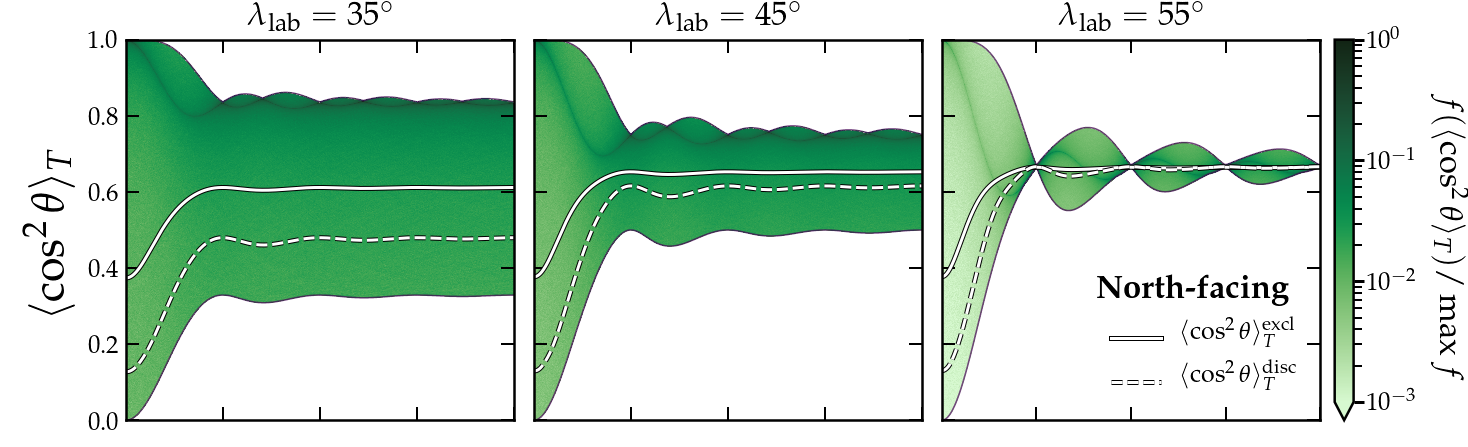

In [22]:
#xlab = r'$T$ [days]'
xlab = ''
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'

fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_excl,C1_disc,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_excl,C2_disc,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_excl,C3_disc,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

ax1.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat1))+r'$^\circ$',fontsize=33)
ax2.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat2))+r'$^\circ$',fontsize=33)
ax3.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat3))+r'$^\circ$',fontsize=33)

ax3.legend(frameon=False,bbox_to_anchor=(1,0),fontsize=25,loc='lower right')

plt.gcf().text(0.86,0.37,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

MySaveFig(fig,figname)

In [23]:
direction_label = r'{\bf Zenith-facing}'
figname = 'ZenithFacing_costh_dist'
cmap = cm.Reds
T,ce,H1,C1_excl,C1_disc = costh_T_histogram(costh2NW,lat1,4)
T,ce,H2,C2_excl,C2_disc = costh_T_histogram(costh2NW,lat2,4)
T,ce,H3,C3_excl,C3_disc = costh_T_histogram(costh2NW,lat3,4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


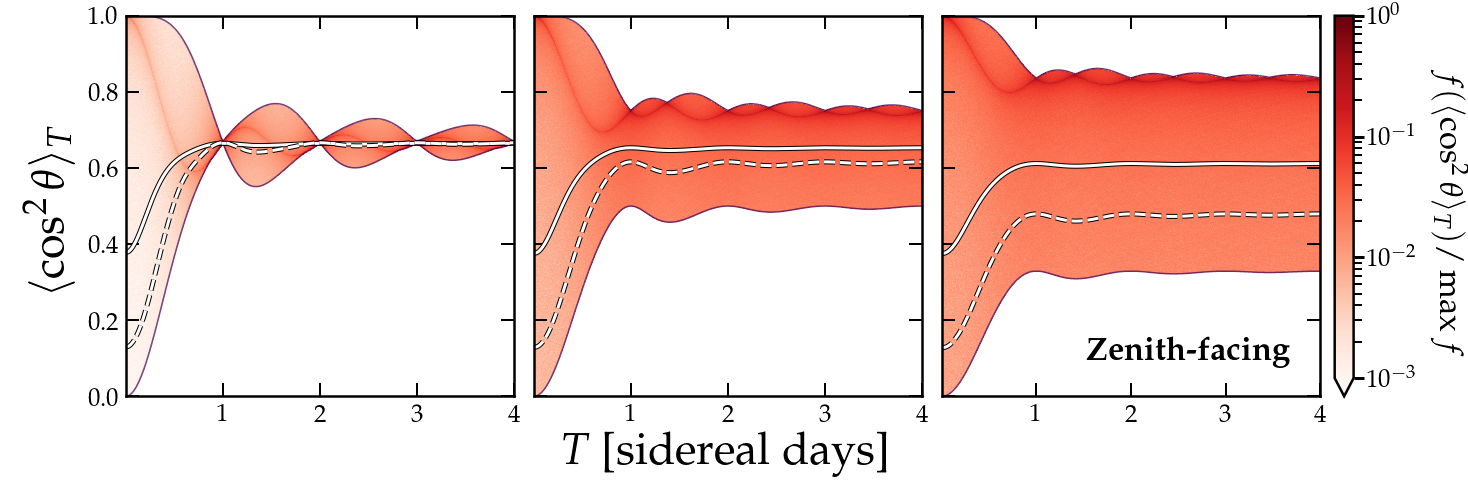

In [24]:
xlab = r'$T$ [sidereal days]'
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'

fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_excl,C1_disc,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_excl,C2_disc,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_excl,C3_disc,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

plt.gcf().text(0.86,0.2,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])

MySaveFig(fig,figname)

In [25]:
direction_label = r'{\bf West-facing}'
figname = 'WestFacing_costh_dist'
cmap = cm.Blues
T,ce,H1,C1_excl,C1_disc = costh_T_histogram(costh2ZN,lat1,4)
T,ce,H2,C2_excl,C2_disc = costh_T_histogram(costh2ZN,lat2,4)
T,ce,H3,C3_excl,C3_disc = costh_T_histogram(costh2ZN,lat3,4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


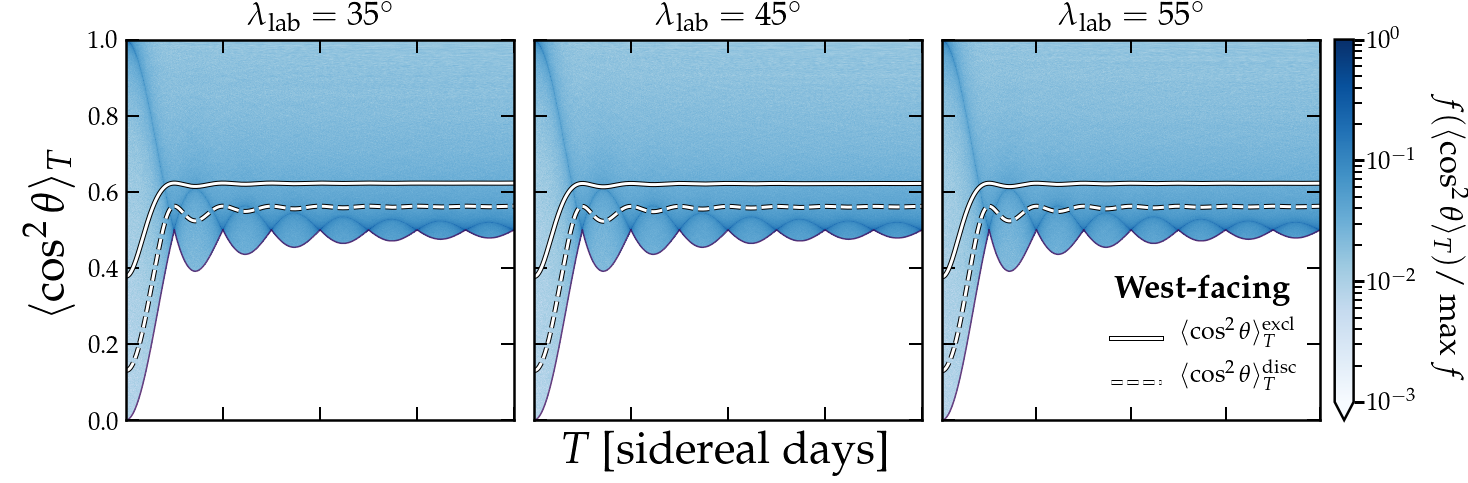

In [26]:
xlab = r'$T$ [sidereal days]'
ylab = r'$\langle\cos^2{\theta}\rangle_T$'
cbar_lab = r'$f(\langle\cos^2{\theta}\rangle_T)/\max{f}$'

fig,ax1,ax2,ax3 = MyTriplePlot(xlab2=xlab,ylab1=ylab,wspace=0.05,width_ratios=[1,1,1.06],size_x=22)

Plot_costh_T_histogram(ax1,T,ce,H1,C1_excl,C1_disc,cmap,lat1,direction_label)
Plot_costh_T_histogram(ax2,T,ce,H2,C2_excl,C2_disc,cmap,lat2,direction_label)
Plot_costh_T_histogram(ax3,T,ce,H3,C3_excl,C3_disc,cmap,lat3,direction_label,cbar_lab=cbar_lab,cbar_on=True)

ax1.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat1))+r'$^\circ$',fontsize=33)
ax2.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat2))+r'$^\circ$',fontsize=33)
ax3.set_title(r'$\lambda_{\rm lab} = $ '+str(int(lat3))+r'$^\circ$',fontsize=33)

ax3.legend(frameon=False,bbox_to_anchor=(1,0),fontsize=25,loc='lower right')

plt.gcf().text(0.86,0.37,direction_label,fontsize=33,ha='right')
plt.gcf().text(0.05,0.1,'--',color='w')
ax3.set_yticklabels([])
ax2.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])

MySaveFig(fig,figname)